In [ ]:
!pip install gensim

  Found existing installation: Cython 0.29.13
    Uninstalling Cython-0.29.13:
      Successfully uninstalled Cython-0.29.13


# Import

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import re
import numpy as np 
import pandas as pd 

pd.set_option('display.max_colwidth', -1)

# dataset
from sklearn.datasets import fetch_20newsgroups

# Gensim packages
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [12]:
# loading dataset
news_group = fetch_20newsgroups(subset='train')

news_group_data = news_group.data
news_group_target_names = news_group.target_names
news_group_target = news_group.target

In [13]:
# Creating a dataframe from the loaded data
news_df = pd.DataFrame({'news': news_group_data, 
                        'class': news_group_target})

In [5]:
news_df.head()

,news,class
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",7
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.\n\nGuy Kuo <guykuo@u.washington.edu>\n",4
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""wow"" or is it really that good?). could i solicit\nsome opinions of people who use the 160 and 180 day-to-day on if its worth\ntaking the disk size and money hit to get the active display? (i realize\nthis is a real subjective question, but i've only played around with the\nmachines in a computer store breifly and figured the opinions of somebody\nwho actually uses the machine daily might prove helpful).\n\n* how well does hellcats perform? ;)\n\nthanks a bunch in advance for any info - if you could email, i'll post a\nsummary (news reading time is at a premium with finals just around the\ncorner... :( )\n--\nTom Willis \ twillis@ecn.purdue.edu \ Purdue Electrical Engineering\n---------------------------------------------------------------------------\n""Convictions are more dangerous enemies of truth than lies."" - F. W.\nNietzsche\n",4
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@cla

In [14]:
#randomly taking sample
news_extracts = news_df.sample(2000)
X = news_df['news']
y = news_df['class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#I use these samples for testing the steps without waiting a long time
sample_size = 2000
X_sample = X_train.iloc[0:sample_size] #rows, columns
y_sample = y_train.iloc[0:sample_size] #rows, columns
news_extracts.reset_index(drop=True, inplace=True)
news_extracts.head(2)

,news,class
0,"From: tquinn@heartland.bradley.edu (Terry Quinn)\nSubject: Waxing a new car\nOrganization: UTexas Mail-to-News Gateway\nLines: 18\nReply-To: tquinn@heartland.bradley.edu\nNNTP-Posting-Host: cs.utexas.edu\n\n\n\nI have just taken delivery on a new GM car (Firebird) with a \nclearcoat finish. I assume that it is probably urethane since the \nindustry has moved in that direction in paints.\n \nIn years past, it used to be recommended that owners wait up to \n60 days before you wax a car, for the paint to ""cure."" The dealer \nshop manager said this also, but I'm not sure that he wasn't just \nbasing it on past tradition. Does anyone know if this is still a \nrecommended practice, or is it better to go ahead and wax right \naway (non-abrasive new car wax) with the newer finishes? \n\n--\n Terry Quinn\n Germantown Hills, IL\n tquinn@heartland.bradley.edu\nfrom Compuserve . . . >INTERNET: tquinn@heartland.bradley.edu\n",7
1,"From: howard@sharps.astro.wisc.edu (Greg Howard)\nSubject: Re: PLANETS STILL: IMAGES ORBIT BY ETHER TWIST\nOrganization: University of Wisconsin - Astronomy Department\nLines: 10\nNNTP-Posting-Host: uwast.astro.wisc.edu\n\n\nActually, the ""ether"" stuff sounded a fair bit like a bizzare,\nqualitative corruption of general relativity. nothing to do with\nthe old-fashioned, ether, though. maybe somebody could loan him\na GR text at a low level.\n\ndidn't get much further than that, tho.... whew.\n\n\ngreg\n",14


### Pre-Processing

In [ ]:
# "\s"	Most engines: "whitespace character": space, tab, newline, carriage return,
# "\w" means "any word character" which usually means alphanumeric (letters, numbers, regardless of case) plus underscore (_)
# more info https://www.rexegg.com/regex-quickstart.html

In [15]:
# Custom filter method
transform_to_lower = lambda s: s.lower() #upper to lower case

remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s) #regex to remove single char

# Filters to be executed in pipeline
CLEAN_FILTERS = [strip_tags,
                strip_numeric,
                strip_punctuation, 
                strip_multiple_whitespaces, 
                transform_to_lower,
                remove_stopwords,
                remove_single_char,stem_text] #stemming text

# Method does the filtering of all the unrelevant text elements
def cleaning_pipe(document):
    # Invoking gensim.parsing.preprocess_string method with set of filters
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return processed_words

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9cfe2bfd0>,
               classes=None, colormap=None, colors=None, decompose=None,
               decompose_by=None, labels=None, random_state=None)

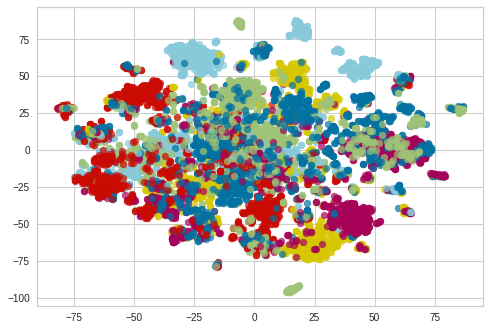

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
tfidf = TfidfVectorizer(tokenizer=cleaning_pipe)

X = tfidf.fit_transform(X_train)
y = y_train

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
#tsne.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FrequencyVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f39e626ce90>,
                    color=None,
                    features=['\x08', '\x08a', '\x08c', '\x08d', '\x08e',
                              '\x08i', '\x08l', '\x08m', '\x08r', '\x08s',
                              '\x18', '\x1a', '\x1b', 'aa', 'aaa', 'aaaa',
                              'aaaaaaaaaaaa',
                              'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg',
                              'aaaaagggghhhh', 'aaaarrgghhhh', 'aaabett',
                              'aaadeion', 'aaah', 'aaahh', 'aaahhhh', 'aaai',
                              'aaaweek', 'aacc', 'aachen', 'aad', ...],
                    n=None, orient='v')

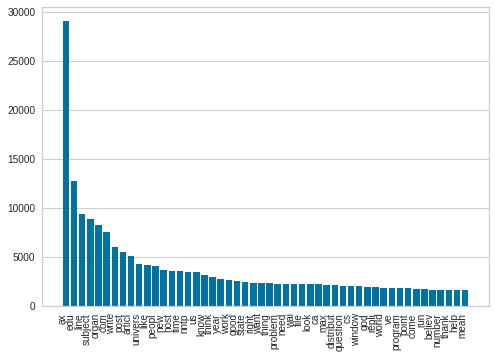

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer


vectorizer = CountVectorizer(tokenizer=cleaning_pipe)
docs       = vectorizer.fit_transform(X_train)
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
#visualizer.show()

Accuracy: 0.9222340049487452, Time duration: 6.506285667419434


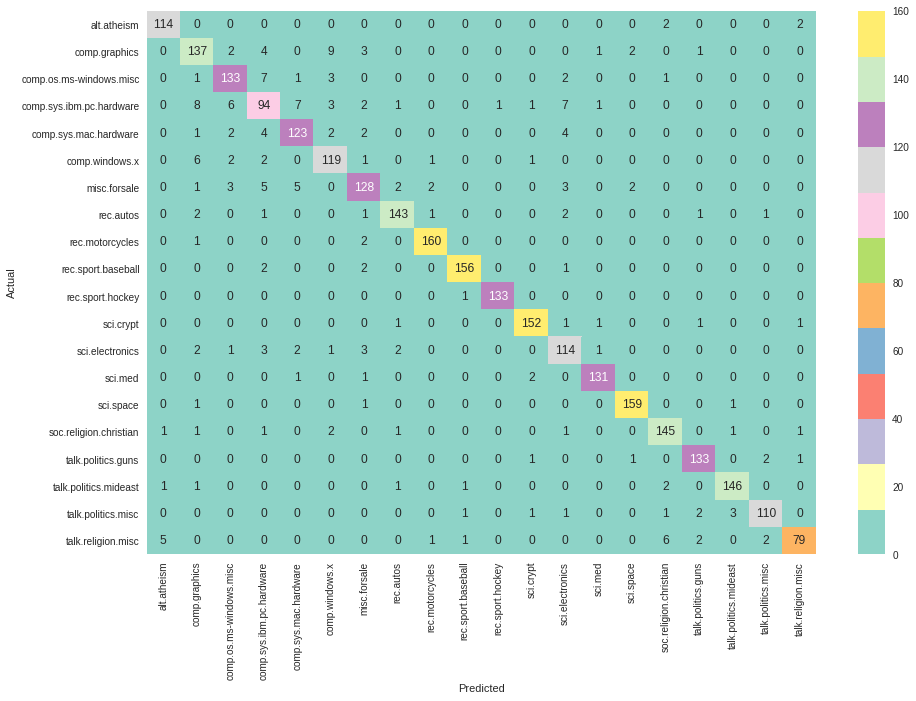

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
import seaborn as sns



start = time.time()
classifier = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english') + list(string.punctuation))),('classifier', LinearSVC(C=10))])
classifier.fit(X_train, y_train)
end = time.time()
labels= ['alt.atheism',
'comp.graphics',
'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware',
'comp.sys.mac.hardware',
'comp.windows.x',
'misc.forsale',
'rec.autos',
'rec.motorcycles',
'rec.sport.baseball',
'rec.sport.hockey',
'sci.crypt',
'sci.electronics',
'sci.med',
'sci.space',
'soc.religion.christian',
'talk.politics.guns',
'talk.politics.mideast',
'talk.politics.misc',
'talk.religion.misc']

print("Accuracy: " + str(classifier.score(X_test, y_test)) + ", Time duration: " + str(end - start))

y_pred = classifier.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [28]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=labels))

                          precision    recall  f1-score   support

             alt.atheism       0.94      0.97      0.95       118
           comp.graphics       0.85      0.86      0.85       159
 comp.os.ms-windows.misc       0.89      0.90      0.90       148
comp.sys.ibm.pc.hardware       0.76      0.72      0.74       131
   comp.sys.mac.hardware       0.88      0.89      0.89       138
          comp.windows.x       0.86      0.90      0.88       132
            misc.forsale       0.88      0.85      0.86       151
               rec.autos       0.95      0.94      0.94       152
         rec.motorcycles       0.97      0.98      0.98       163
      rec.sport.baseball       0.97      0.97      0.97       161
        rec.sport.hockey       0.99      0.99      0.99       134
               sci.crypt       0.96      0.97      0.97       157
         sci.electronics       0.84      0.88      0.86       129
                 sci.med       0.97      0.97      0.97       135
         

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
bow_clf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=cleaning_pipe, max_df=0.3, min_df=0.001, max_features=100000)),
    ('clf',   MultinomialNB())])

In [ ]:
from sklearn.metrics import classification_report
bow_clf.fit(X_train, y_train)
y_pred = bow_clf.predict(X_test)
cr = classification_report(y_test, y_pred)
print('Classification report:\n\n{}'.format(
    classification_report(y_test, y_pred))
)

Classification report:

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       127
           1       0.80      0.80      0.80       147
           2       0.74      0.82      0.78       142
           3       0.70      0.83      0.76       143
           4       0.88      0.78      0.82       154
           5       0.89      0.84      0.86       154
           6       0.83      0.78      0.80       121
           7       0.91      0.92      0.91       149
           8       0.93      0.94      0.93       146
           9       0.92      0.95      0.93       150
          10       0.95      0.96      0.95       164
          11       0.95      0.96      0.96       163
          12       0.84      0.80      0.82       137
          13       0.97      0.93      0.95       132
          14       0.91      0.97      0.94       153
          15       0.73      0.95      0.83       167
          16       0.84      0.96      0.90       127
   

## Alternate Method

In [ ]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

In [ ]:
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
print("\n".join(twenty_train.data[0].split("\n")[:3]))

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape


(11314, 130107)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(11314, 130107)

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape


(11314, 130107)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [ ]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => rec.autos


In [ ]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [ ]:
text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)

0.7738980350504514

In [ ]:
from sklearn.metrics import classification_report
text_clf.fit(twenty_train.data, twenty_train.target)
y_pred = text_clf.predict(twenty_test.data)
cr = classification_report(twenty_test.target, y_pred)
print('Classification report:\n\n{}'.format(
    classification_report(twenty_test.target, y_pred))
)

Classification report:

              precision    recall  f1-score   support

           0       0.80      0.52      0.63       319
           1       0.81      0.65      0.72       389
           2       0.82      0.65      0.73       394
           3       0.67      0.78      0.72       392
           4       0.86      0.77      0.81       385
           5       0.89      0.75      0.82       395
           6       0.93      0.69      0.80       390
           7       0.85      0.92      0.88       396
           8       0.94      0.93      0.93       398
           9       0.92      0.90      0.91       397
          10       0.89      0.97      0.93       399
          11       0.59      0.97      0.74       396
          12       0.84      0.60      0.70       393
          13       0.92      0.74      0.82       396
          14       0.84      0.89      0.87       394
          15       0.44      0.98      0.61       398
          16       0.64      0.94      0.76       364
   

## Misc

In [ ]:
# Apply the cleaning pipe on the news data

news_extracts['clean_text'] = news_extracts['news'].apply(cleaning_pipe)
news_extracts['clean_text'][0:2]

0    [aweslei, vela, ac, oakland, edu, aweslei, subject, silli, outdat, koresh, miranda, organ, oakland, univers, rochest, michigan, line, nntp, post, host, vela, ac, oakland, edu, scottj, magic, dml, georgetown, edu, johnscott, write, issu, tank, detroit, fire, main, gun, incorrectread, resort, falsehood, attempt, point, risk, bore, belabor, point, claim, chain, tank, detroit, text, follow, mere, claim, tank, claim, fire, main, gun, suppress, sniper, effect, coffman, claim, apc, told, main, gun, continu, awai, claim, defend, disput, poster, respond, disput, us, tank, post, rude, gari, coffmanmain, gun, geeentir, point, go, admit, wrong, entir, point, exactli, claim, ve, heard, ey, wit, descript, tank, main, gun, ...]
1    [graham, toal, subject, tap, code, good, origin, gtoal, pizzabox, demon, uk, nntp, post, host, pizzabox, demon, uk, repli, graham, toal, organ, cuddlehog, anonym, distribut, na, line, articl, pat, rwing, uucp, pat, myrto, write, clinton, clipper, good, algrithm, publ

In [ ]:
news_extracts.head()

news  \
0  From: awesley@vela.acs.oakland.edu (awesley)\nSubject: Re: That silly outdated Bill (was Re: Koresh and Miranda)\nOrganization: Oakland University, Rochester, Michigan, U.S.A.\nLines: 115\nNNTP-Posting-Host: vela.acs.oakland.edu\n\nscottj@magic.dml.georgetown.edu (John L. Scott) writes:\n\n\n: The issue has never been whether tanks were used in Detroit in 1967.  It\n: has been whether they fired their main guns.  \n\nNever?  This is incorrect.  Either you don't read very well or resort\nto falsehoods in an attempt to make a point.\n\nAt the risk of boring and belaboring the point, my claim was\nthe chain was regarding the tanks "last used in Detroit in 48".\nThe text follows.\n\n:  You did not merely claim that\n: tanks were used--you claimed that they fired their main guns to suppress\n: sniper fire and that they were "quite" effective at this.  \n\nIndeed, when Coffman claimed they were only used as APCs, I did say\nI had been told they did fire their main guns.  \n  ^^^^^^^^^^^^^\n: You continue to\n: back away from this claim and defend something else that nobody is\n: disputing.\n\nWell, the poster who I responded to did dispute the use of tanks\npost-48.  Rude of you to call Gary Coffman a nobody.  \n\n: "Well, it's not the main gun."  Gee, that's only the entire point.  Are you\n: now going to admit that you were wrong?\n\nThat was the entire point to *you*.  What exactly did I claim?\n   --------------------------------------------------\n  "I've heard eye-witness descriptions of tanks using their main guns\nto respond to sniper fire.  Quite effectively."\n   --------------------------------------------------\n\n  I wasn't wrong . . . I've heard those descriptions.  If you're\npaying attention, I've mentioned that I saw the tanks with my own\neyes, but the main gun firing was an account I heard.  That helps\npeople judge whether or not to kick in the, to use your words,\n"bullshit filters".  Stating that I *claimed* this is a falsehood.\n\n  What was it I claimed as fact?  Here's the entire post:\n  --------------------------------------------------\n>We haven't used tanks against the black ghettos since Detroit 1948. \n\nCorrection.  I know they used tanks in Detroit 1968.  I saw em, it\nwas well covered in the news at that time.  Gordon Lightfoot mentions\nit in his song "Black Day in July".\n  --------------------------------------------------\n\n  Since you don't dispute that and claim that nobody else does, that\nmeans I was right.  \n\n: I will never read of tanks firing their main guns in Detroit in the '67\n: riots.  There is simply no way that such an event could have taken place\n: without it being common knowledge even 26 years later.  The American\n: military firing shells from tanks in American cities on blacks would have\n: been *big* news.\n\n   So one would suppose.  Some folks think in happened in 48.  \n\nAwesley goes on:\n  You can also read of the troops using grenade launchers.\n\n: To fire fragmentary grenades?  I doubt that as well.  To fire concussion\n: grenades?  Perhaps.  To fire tear gas?  Certainly.  But you would be\n: perfectly willing to let us believe they fired frags, wouldn't you, since\n: it makes your other claim seem more plausible.\n\nJohn, again, strawman techniques.  Do you feel you're losing it so you\nhave to stretch what I said and knock that down?  What I read said\nnothing about what they fired.  And so I put nothing in there.  If you\nneed some help, let me know and I'l take your side of this for a\nwhile.  You're not scoring here, you're boring here. \n\n: If tanks had fired their main guns in Detroit, people would have been\n: screaming about it for the past two and half decades.  I would know about\n: it. \n\n   Glad to know you're such an expert.  Nice to hear some an\nauthority.  I especially appreciate your basis of knowledge -- if it\nhad happened, you would have know it.  Since you are such an\nauthority, you probably know that people did scream about an

## Bag of Words

In [ ]:
from gensim import corpora

dictionary = corpora.Dictionary(news_extracts['clean_text'])
print(dictionary)

Dictionary(37735 unique tokens: ['abc', 'access', 'actual', 'address', 'appl']...)


In [ ]:
print(dictionary.token2id)

{'abc': 0, 'access': 1, 'actual': 2, 'address': 3, 'appl': 4, 'articletsoft': 5, 'ask': 6, 'avail': 7, 'bb': 8, 'bn': 9, 'boughthelp': 10, 'btw': 11, 'bulk': 12, 'buyer': 13, 'capril': 14, 'case': 15, 'catalog': 16, 'cjccg': 17, 'clean': 18, 'comexpect': 19, 'compani': 20, 'cool': 21, 'ct': 22, 'current': 23, 'databas': 24, 'delet': 25, 'direct': 26, 'distribut': 27, 'dupe': 28, 'employ': 29, 'enhanc': 30, 'exampl': 31, 'express': 32, 'futur': 33, 'get': 34, 'hard': 35, 'havenguessedus': 36, 'hei': 37, 'hottest': 38, 'isneffect': 39, 'joe': 40, 'joecool': 41, 'josephcool': 42, 'junk': 43, 'know': 44, 'knowsel': 45, 'larg': 46, 'let': 47, 'like': 48, 'line': 49, 'list': 50, 'll': 51, 'magazin': 52, 'mail': 53, 'mailer': 54, 'maintain': 55, 'major': 56, 'market': 57, 'matsumura': 58, 'matthew': 59, 'media': 60, 'method': 61, 'move': 62, 'ms': 63, 'ncoa': 64, 'nd': 65, 'net': 66, 'new': 67, 'opinion': 68, 'organ': 69, 'origin': 70, 'pc': 71, 'pick': 72, 'product': 73, 'public': 74, 'rang'

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(news_extracts['clean_text'], min_count=1)

In [ ]:
print(model)

Word2Vec(vocab=37735, vector_size=100, alpha=0.025)


# LDA

In [ ]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaModel
# Create a corpus from a list of texts
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=20)

In [ ]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
common_dictionary = Dictionary(common_texts)
other_corpus = [common_dictionary.doc2bow(text) for text in news_extracts['clean_text']]

In [ ]:
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=20)
# Save model to disk.
temp_file = datapath("model")
lda.save(temp_file)

In [ ]:
unseen_doc = other_corpus[0]
vector = lda[unseen_doc]  # get topic probability distribution for a document
print(vector)

[(0, 0.025000019), (1, 0.02500002), (2, 0.025000019), (3, 0.025000019), (4, 0.025000019), (5, 0.025000019), (6, 0.025000019), (7, 0.025000019), (8, 0.025000019), (9, 0.025000019), (10, 0.025000019), (11, 0.5249996), (12, 0.025000019), (13, 0.025000019), (14, 0.025000019), (15, 0.025000019), (16, 0.025000019), (17, 0.025000019), (18, 0.025000019), (19, 0.025000019)]
